In [1]:
import sys, os

sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath(".."))

In [37]:
import torch

from prosper_nn.models.ecnn import ECNN
from prosper_nn.models.ensemble import Ensemble

import prosper_nn.utils.generate_time_series_data as gtsd
import prosper_nn.utils.create_input_ecnn_hcnn as ci
import prosper_nn.utils.neuron_correlation_hidden_layers as nchl

from prosper_nn.utils import visualize_forecasts
from prosper_nn.utils import sensitivity_analysis

torch.manual_seed(0)

#  Error Correction Neural Network
This notebook demonstrates how to build and analyse an Error Correction Neural Network with the Prosper package.

It begins with a theoretical introduction to ECNNs. Then one single ECNN is applied, including an explanation of how the input and the target data should look like, how to train the model and how to find the right hyperparameters. Subsequently, an ensemble of ECNNs is constructed to produce more reliable predictions. The uncertainty of the ensemble prediction is visualised. Finally, we use the sensitivity analysis to investigate the influence of the input features on the forecasts.

## Theory

An Error Correction Neural Network belongs to the class of Recurrent Neural Networks. In the picture below we see the architecture of the model. It can be used to forecast a time series. The basic architecture (only the black lines in the image below) is equal to a basic RNN. At every time step there is an input $U$ (which can contain multiple features) and a target $Y$ (which can also contain multiple features). The gray background of the state $s$ symbolizes that there's a non-linearity applied. Thus, the ECNN can be interpreted as a non-linear version of an ARIMAX.

As long as the target $Y_t$ is available, it is used to calculate the absolute error (node $tar=0$) between the prediciton ($ \hat{y}_t = Cs_t $) and the target data : $\hat{y}_{t-1} - y_{t-1}$.  This absolute error is used to improve the next state with the matrix $D$. This **error correction** gave the name for this model and helps and speeds up training. During training, this error between expectation of the model ($\hat{y}$) and the real observations ($y$) is brought down very close to zero. This means, that the model architecture converges back to the original one (only black lines left).

Overall, we calculate $s_t$ and $\hat{y}$ as:
$$ s_t = tanh(As_{t-1} + Bu_t + D(\hat{y}_{t-1} - y_{t-1}))$$
$$ \hat{y}_t = Cs_t $$

And the term to be minimized with training is:
$$ \sum_{t=0}^{T} tar_{t}^{2} = \sum_{t=0}^{T}(\hat{y}_{t} - y_{t})^{2} \rightarrow min $$

If the values of $U$ are not known for the future, only the state transition matrix $A$ and the matrix $C$ are used to calculate $\hat{y}$. This is why ECNNs are mostly suited for short-term forecasts. In this case the formula to calculate $s_{t+1}$ looks like this:

$$s_{t+1} = tanh(As_{t} + D(\hat{y}_{t} - y_{t}))$$

This is the last step where an error correction is possible because $y_t$ is the last observation we know. So starting with $s_{t+2}$ the formula looks like this:

$$s_{t+2} = tanh(As_{t+1})$$

The below image depicts the input of time $t$ to have direct influence on the state at time $t$. In the implementation of the ECNN in prosper_nn, this translates to the approach being set to 'backwards'. There are use cases, where we can assume that there is a lag in the impact of $U$ on $s$ (and therefore on $Y$). If you set approach to be 'forward', the $U$'s are shifted to the right and $U_t$ can only have impact on the $s_{t+1}$ and following.

<img src=images/Architecture_ECNN.png width=1000 >

In the implementation of the ECNN architecture in prosper_nn the ECNN is stacked together by adding multiple [ECNN cells](../api/ecnn.rst#prosper_nn.models.ecnn.ecnn_cell.ECNNCell). Every cell gets the hidden state of the last time step $t-1$, the $Y$ observation of the last time step $t-1$ and the $U$ input of the present time step $t$. The cell then outputs the model error at $t-1$ and the new state at time $t$.

Below, we see the four options to initialize an ECNN. They differ in the mentioned 'approach' (backward or forward) and also in the parameter ``future_U``, which defines if the input $U$ is available for the future. If not, only the matrices $A$ and $C$ are used to generate future states and the forecast of $Y$. To use $U$ for the forecast, you have to know $U$ for the future. This can be the case for input features like weekdays, months or holidays, but maybe also for features for which there's already a very reliable forecast.

The following image shows the backward approach without using future values of $U$ for forecasting.

<img src=images/ECNN_backward1.png width=1000 >

Here, the approach is still backward, but the future $U$ is used for forecasting.

<img src=images/ECNN_backward2.png width=1000 >

Now, the following picture shows the forward approach and no future $U$.

<img src=images/ECNN_forward1.png width=1000 >

And finally, the forward approach combined with the use of future $U$ for forecasting.

<img src=images/ECNN_forward2.png width=1000 >

Additionally, a form of the GRU variant 3 from Dey and Salem (2017) can be used for ECNNs. The respective formula is:
$$s_t = (1- \sigma(update\_vector)) \circ s_{t-1} + \sigma(update\_vector) \circ (tanh(As_{t-1} + Bu_t))$$
If the update vector has large values, the sigmoid function converges toward 1 and the architecture defaults to the regular ECNN archictecture. On the other hand, if the update vector contains large negative values, then $s_t=s_{t-1}$ and there is total memory.

The variant is implemented by using [GRU_3_variant](../api/ecnn.rst#prosper_nn.models.ecnn.gru_cell_variant.GRU_3_variant) for the state transition.

The architecture is demonstrated in the following image:

Dey and Salem (2017):
R. Dey and F. M. Salem, "Gate-variants of Gated Recurrent Unit (GRU) neural networks," 2017 IEEE 60th International Midwest Symposium on Circuits and Systems (MWSCAS), Boston, MA, USA, 2017, pp. 1597-1600, doi: 10.1109/MWSCAS.2017.8053243.


<img src=images/ECNN_LSTM_Architecture.png width=1000 >

## Data preparation

ECNNs need two inputs, the ``external features U`` and the ``target Y``. Both need to be `torch.Tensors`. 

Y must be of `shape=(past_horizon, batchsize, n_features_Y)`. 

The ``past_horizon`` is an int indicating the number of time steps into the past used for training and forecasting. If you have e.g. monthly data, `past_horizon` set to 3 means that the past 3 months are used for forecasting.  
The ``batchsize`` is the number of samples in a batch used for training.  
``n_features_Y`` represents the number of features in Y. It is possible to do multivariate forecasts, which means that in this case `n_features_Y` needs to be larger than 1.

U must be either of `shape=(past_horizon, batchsize, n_features_U)` or `shape=(past_horizon+forecast_horizon, batchsize, n_features_U)`, depending on future_U. If you are able to use the future external features for forecasting, your U should be of the second shape. 

past_horizon, batchsize and n_features_U are analogous to Y.  
The ``forecast_horizon`` gives the steps you want to predict into the future. If you have daily data and forecast_horizon set to 4, the forecast will be for the next 4 days. 

We will now generate a dummy data set and then put it in the shape we need. Prosper_nn has implemented two functions to do just that.

First, we have to define the mentioned parameters.

In [3]:
past_horizon = 10
batchsize = 5
n_features_Y = 2
n_features_U = 3

forecast_horizon = 3

Then we need to tell the function sample_data how long the time series of Y and U should be.

In [4]:
n_data = 150  # number of time steps of the time series Y and U

Y, U = gtsd.sample_data(n_data, n_features_Y, n_features_U)

Now we need to decide if we want the future U to be used for forecasting. We do this by setting the parameter future_U.

In [5]:
future_U = False

We use the function create_input to turn Y and U into batches by applying a sliding window.

In [6]:
Y_batches, U_batches = ci.create_input(
    Y, past_horizon, batchsize, U, future_U, forecast_horizon
)

C:\Users\bkn\AppData\Local\Temp\ipykernel_4436\3941169119.py:1: UserWarning: The number of sequences generated from the data are not a multiple of batchsize. The first 1 sequences will be discarded.
  Y_batches, U_batches = ci.create_input(


Let's have a look at Y_batches and U_batches.

In [7]:
print(Y_batches.shape)
print(Y_batches[0].shape)  # first batch

print(U_batches.shape)
print(U_batches[0].shape)  # first batch

torch.Size([28, 10, 5, 2])
torch.Size([10, 5, 2])
torch.Size([28, 10, 5, 3])
torch.Size([10, 5, 3])


In the ECNN implementation the prediction error is used as the output of the model. By training this error to zero, we train the model to predict Y. This is why the ``target`` is a tensor of zeros with the same size as one batch of Y.

In [8]:
targets = torch.zeros((past_horizon, batchsize, n_features_Y))

## Single Error Correction Neural Network

### Initialization

Before initializing the model, we set some parameters.
The parameter ``n_state_neurons`` defines the number of the state neurons used in $s_t$.
As default we use  ``'elman'`` as ``recurrent_cell_type``, which builds an Elman RNN with error correction. However, there is a simpler form of GRU variant 3 (Dey and Salem, 2017) implemented. By setting ``recurrent_cell_type`` to ``'gru_3_variant'``, this is used. The ``lstm`` and ``gru`` cell is also supported.
The ECNN knows two ``approaches``, ``backward`` and ``forward``. If approach is set to backward, U at time t is used in the model to predict Y at time t. If approach is set to forward, U at time t is used only to predict Y at time t+1. This way, you can implement your belief in there being a delay in the impact of U on Y.
There is the possibility to set the initial state of the ECNN by giving a tensor of the right dimensions as ``init_state``. If none is provided, the hidden state is initialized randomly.
We can decide whether that initial state is fixed or it should be learned as a trainable parameter. This is done by setting ``learn_init_state``.
The activation function used in the ECNN cells is set by ``activation`` (default: tanh). 

In [9]:
n_state_neurons = 4
recurrent_cell_type = 'elman'
approach = "backward"
init_state = torch.zeros(1, n_state_neurons)
learn_init_state = True
activation = torch.tanh

ecnn = ECNN(
    n_features_U=n_features_U,
    n_state_neurons=n_state_neurons,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    recurrent_cell_type=recurrent_cell_type,
    approach=approach,
    init_state=init_state,
    learn_init_state=learn_init_state,
    activation=activation,
    n_features_Y=n_features_Y,
    future_U=future_U,
)

### Training loop

To train the model, we have to choose the optimizer and the loss function. We use Adam as optimizer and MSE as the loss function. Note that we give the optimizer the parameters to train and the learning rate.


In [10]:
optimizer = torch.optim.Adam(ecnn.parameters(), lr=0.01)
loss_function = torch.nn.MSELoss()

The number of ``epochs`` defines how often the model is trained on the whole data set. For the sake of speed, we use a  small value. In practice, we use something in the tens of thousands. As common in neural networks we loop over the batches of U and Y in every epoch. For each batch, there is one training step. The model takes the corresponding batches of U and Y as input and outputs the ``past_error`` and the ``forecast`` of the model (in one tensor, but the first past_horizon entries are the past error and the remaining forecast_horizon entries are the forecast). The past error is calculated for each feature in Y and each time step of the past horizon. Where we don't know the real Y, the model outputs its forecast.
By comparing the past error and the target using the loss function, we obtain the loss used for backpropagation. 

In [11]:
epochs = 100

total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, U_batches.shape[0]):
        # set the gradient back to zero, otherwise it would just add up
        ecnn.zero_grad()

        # put data through model and get model output
        U_batch = U_batches[batch_index]
        Y_batch = Y_batches[batch_index]
        model_output = ecnn(U_batch, Y_batch)
        past_error, forecast = torch.split(model_output, past_horizon)

        # calculate loss and gradients
        losses = [loss_function(past_error[i], targets[i]) for i in range(past_horizon)]
        loss = sum(losses)
        loss.backward()

        # do training step
        optimizer.step()
        # save loss for plotting etc.
        total_loss[epoch] += loss.detach()

### Forecast

We trained the ECNN on batches, but the final forecast we usually want to do on only one time series. In general, this will be the last past_horizon time steps up to the present.  
So let's take the last row of the last U_batch and the row of the last Y_batch and use that for forecasting. But we have to unsqueeze them because the dimension 1 has to hold the batchsize (which equals 1 in this case).

In [12]:
U_forecast = U_batches[-1, :, -1, :].unsqueeze(1)
print(U_forecast.shape)
Y_forecast = Y_batches[-1, :, -1, :].unsqueeze(1)
print(Y_forecast.shape)

torch.Size([10, 1, 3])
torch.Size([10, 1, 2])


Now, we don't want to do backpropagation when we're forecasting. In order to not calculate or add unnecessary gradients, we set torch.no_grad() and also we set the ecnn model to eval. 

Now we forward the U and Y we want to use for the actual forecast to the trained model. Again, we get the forecast and also the model error on the known Y. If the model is trained and fitted well, this error is close to zero. If we want to calculate the values the model expects for the time steps smaller than $t$, we have to add that error onto Y.

In [13]:
with torch.no_grad():
    ecnn.eval()

    model_output = ecnn(U_forecast, Y_forecast)
    past_errors, forecast = torch.split(model_output, past_horizon)

    expected_timeseries = torch.cat(
        (torch.add(past_errors, Y_forecast), forecast), dim=0
    ).squeeze()

### Evaluation

Prosper_nn has functions to plot the real data and the forecast.

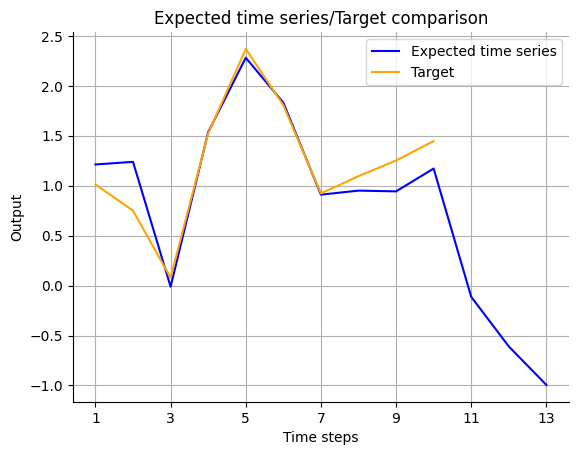

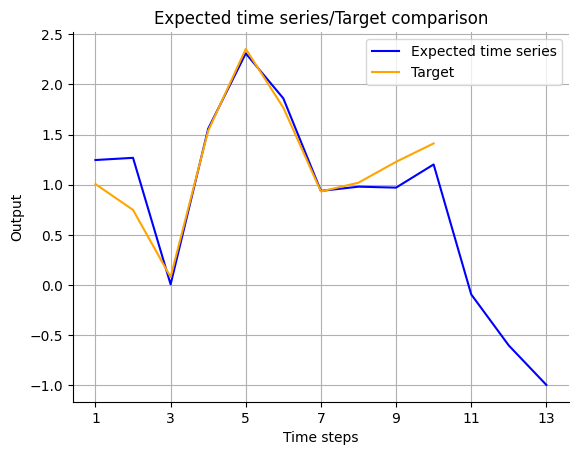

In [14]:
# the first feature in Y
visualize_forecasts.plot_time_series(
    expected_timeseries[:, 0], Y_forecast.squeeze(1)[:, 0]
)
# the second feature in Y
visualize_forecasts.plot_time_series(
    expected_timeseries[:, 1], Y_forecast.squeeze(1)[:, 1]
)

One single model should not be used for forecasting because it's dependent on the random initialization of the parameters. We use an ensemble of ECNNs instead. But looking at a single model can give hints if the architecture is suitable and can help make decisions, for instance on the ``number of neurons`` in $s_t$.

For this purpose, we look at the correlation between the neurons of the hidden state. If two or more neurons produce similar results, only one of them is needed. Then the size of the hidden layer (i.e. n_state_neurons) can be reduced. On the other hand, if none of the neurons have outputs which are strongly correlated, one should consider setting n_state_neurons to a larger number.

We look at the present, i.e. the last time step where the model uses the known Y. We assume that here the hidden state had the most time to be trained. Now we only have to save the state of the model at this time step for each training input and pass that to [hl_size_analysis](../api/neuron_correlation_hidden_layer.rst).

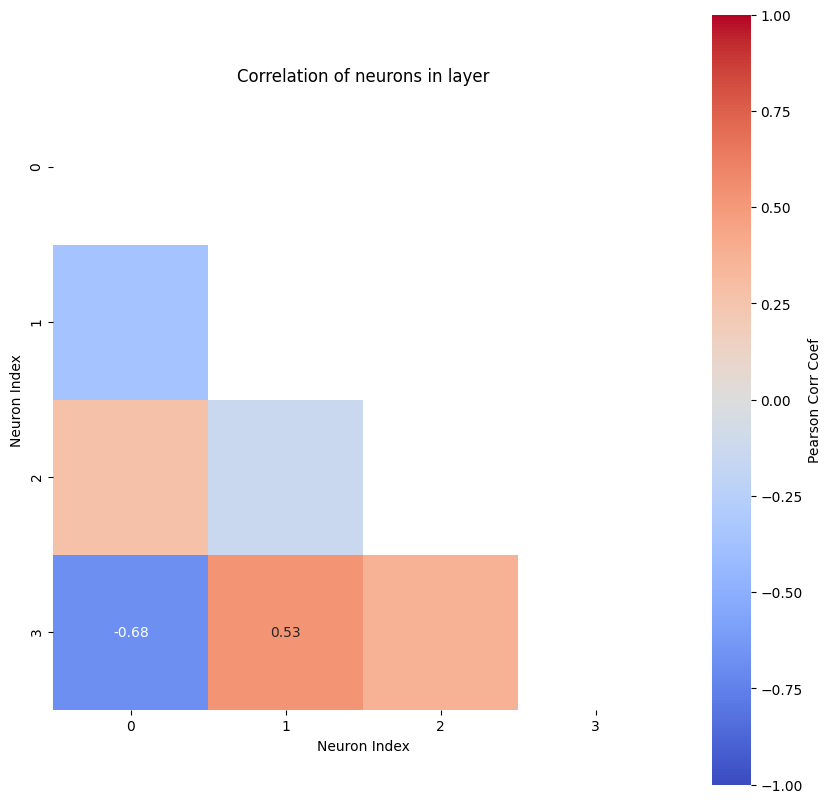

The most correlated neurons are the ones with indices  [3, 0]
The according Pearson correlation coefficient is -0.68


In [15]:
with torch.no_grad():
    # create empty tensor to store states in
    states_for_correlation = torch.empty(
        (Y_batches.shape[0], batchsize, n_state_neurons)
    )

    for batch_index in range(0, Y_batches.shape[0]):
        U_batch = U_batches[batch_index]
        Y_batch = Y_batches[batch_index]
        model_output = ecnn(U_batch, Y_batch)
        # take the state at the present
        states_for_correlation[batch_index] = ecnn.state[past_horizon]
    states_for_correlation = states_for_correlation.reshape((-1, n_state_neurons))

    corr_matrix, max_corr, ind_neurons = nchl.hl_size_analysis(states_for_correlation)

This function shows a plot of the correlations between neurons with color coding and the values of the correlation for relatively strong ones. It also prints out the indices of the neurons with the highest correlation between them and the according Pearson correlation coefficient. Rule of thumb says that if the highest coefficient is larger than 0.8, you can reduce the number of neurons in the hidden layer. If it is smaller, you might try out a larger number of neurons.

For more details on this analysis, see the [notebook for a simple regression](Regression.ipynb#Determine-Hidden-Layer-Dimensionality).

## Ensemble of Error Correction Neural Networks

Let's assume we have a reasonable size of the hidden layer and a single model gives promising results. Now, we use an ensemble for forecasting and inference about the relationship between input and output features. As with the single model we will first initialize the ensemble, then train it and then use it for forecasting. Lastly, we evaluate the trained ensemble.

### Initialization

To initialize the ensemble we first decide the number of models in it. We combine the results of the individual models using the median. 
For the sake of speed, we choose the number of models to be small. In practice, it should be dozens to a few hundreds.

In [16]:
# reset ecnn to use in ensemble
ecnn = ECNN(
    n_features_U=n_features_U,
    n_state_neurons=n_state_neurons,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    recurrent_cell_type='elman',
    approach="backward",
    init_state=init_state,
    learn_init_state=True,
    n_features_Y=n_features_Y,
    future_U=future_U,
)

n_models = 10
ensemble_model = Ensemble(
    model=ecnn, n_models=n_models, combination_type="median"
)

### Training loop

The training of an ensemble is similar to the training of a single model. The difference is that now we get the output for every model in the ensemble plus the median of them. For training, we use the individual errors of each model, but for forecasting we use the median of the whole ensemble.

In [17]:
optimizer = torch.optim.Adam(
    ensemble_model.parameters(), lr=0.01
)  # use parameters of ensemble
loss_function = torch.nn.MSELoss()

epochs = 100
total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, U_batches.size(0)):
        ensemble_model.zero_grad()

        U_batch = U_batches[batch_index]
        Y_batch = Y_batches[batch_index]

        ensemble_output = ensemble_model(U_batch, Y_batch)
        outputs, mean = torch.split(ensemble_output, n_models)
        mean = torch.squeeze(mean, 0)
        past_errors, forecasts = torch.split(outputs, past_horizon, dim=1)

        losses = [
            loss_function(past_errors[j][i], targets[i])
            for j in range(n_models)
            for i in range(past_horizon)
        ]
        loss = sum(losses) / (n_models * past_horizon)
        loss.backward()
        optimizer.step()

        mean_loss = (
            sum([loss_function(mean[i], targets[i]) for i in range(past_horizon)])
            / past_horizon
        )
        total_loss[epoch] += mean_loss.detach()

### Forecast

Forecasting also works similarly with the ensemble, you just have to take care with the output.

In [18]:
with torch.no_grad():
    ensemble_model.eval()

    ensemble_output = ensemble_model(U_forecast, Y_forecast)
    outputs, mean = torch.split(ensemble_output, n_models)
    past_errors, forecasts = torch.split(outputs, past_horizon, dim=1)
    mean_past_error, mean_forecast = torch.split(mean, past_horizon, dim=1)

    expected_timeseries = torch.cat(
        (
            torch.add(mean_past_error.squeeze(0)[:past_horizon], Y_forecast),
            mean_forecast.squeeze(0),
        ),
        dim=0,
    ).squeeze(1)
    expected_timeseries_outputs = torch.cat(
        (torch.add(past_errors, Y_forecast), forecasts), dim=1
    ).squeeze(2)

### Evaluation

#### Uncertainty

Again, let's visualize the forecast. Since we are now looking at an ensemble of models, we are able to not only give a point forecast for each time point. We can also interpret the distribution of the models in the ensemble as the uncertainty of the forecast. For that, we pass the outputs of the individual models as an additional argument to the function we already used for plotting the forecast of a single model.

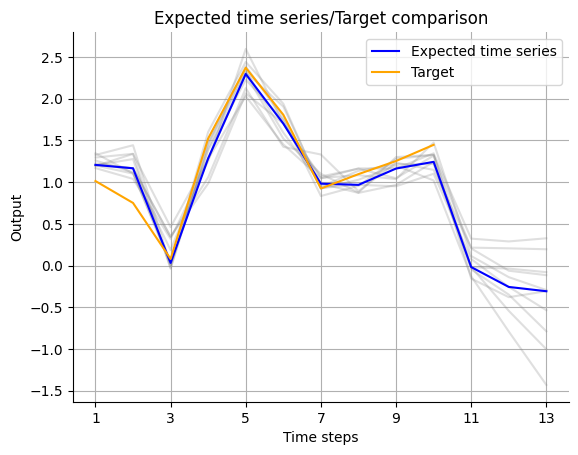

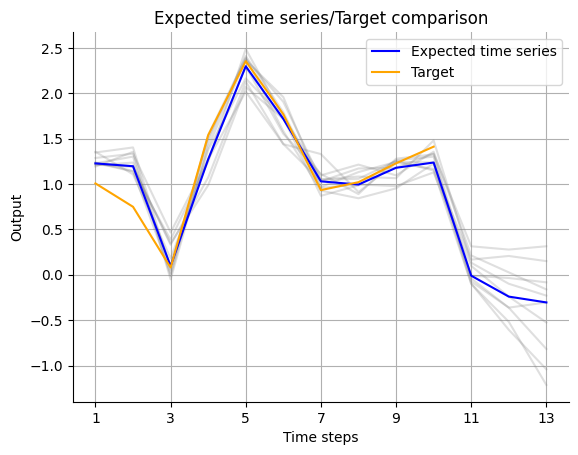

In [19]:
# first feature of Y
visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0],
    target=Y_forecast.squeeze(1)[:, 0],
    uncertainty=expected_timeseries_outputs[:, :, 0].T,
)
# second feature of Y
visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 1],
    target=Y_forecast.squeeze(1)[:, 1],
    uncertainty=expected_timeseries_outputs[:, :, 1].T,
)

A more advanced way of showing the uncertainty comes with the [heatmap_forecasts](../api/visualization.rst) function.

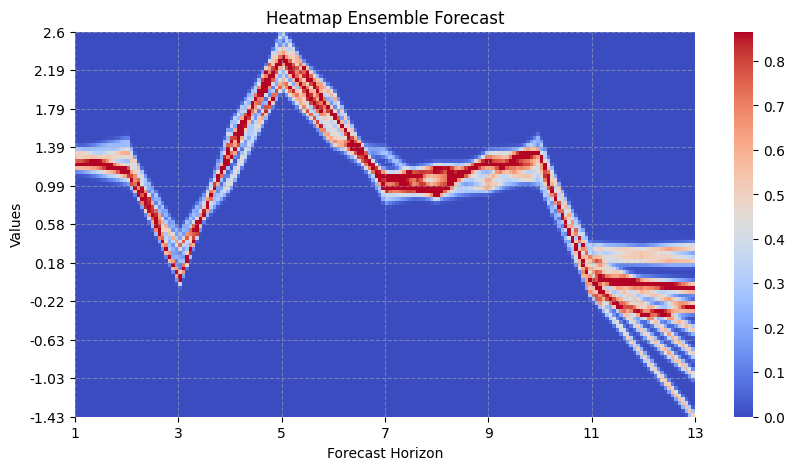

In [20]:
visualize_forecasts.heatmap_forecasts(expected_timeseries_outputs[:, :, 0].T)

#### Sensitivity

We now use the ensemble model to identify the important features of the dataset by analyzing the sensitivity of the target variable in respect to each feature. Apply the sensitivity analysis on the output nodes that you are interested in. Then have a look at the influence of the previous time steps. It can be interesting to find out when the values of the present have the most influence on the forecast.  
Because the sensitivity analysis shows all features for all time steps, it is useful to restrict the analysis on one feature for which the temporal influence should be investigated.

Remember that the ensemble output has the combined expectation and forecast of the whole model in the last entry of the first dimension. Also note that for the analysis of the temporal sensitivity the batchsize must be 1.

In [23]:
Y_batches.shape

torch.Size([140, 10, 1, 2])

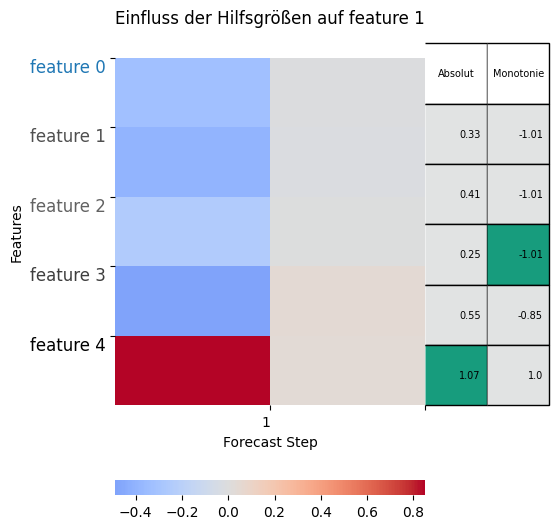

tensor([[[-0.3251, -0.3994, -0.2471, -0.5089,  1.0286],
         [-0.0097, -0.0142, -0.0042,  0.0436,  0.0396]]])

In [38]:
U_batches = U_batches.reshape(-1, past_horizon, 1, n_features_U)
Y_batches = Y_batches.reshape(-1, past_horizon, 1, n_features_Y)

sensitivity_analysis.analyse_temporal_sensitivity(
    model=ensemble_model,
    data=(U_batches, Y_batches),
    task_nodes=[1],
    n_future_steps=forecast_horizon - 1,
    past_horizon=past_horizon,
    n_features=n_features_Y + n_features_U,
)

Because the the ECNN ensemble takes two inputs, we pass them as a tuple for the data argument. ``n_task_nodes`` determines how many of the potentially multiple target features in Y we want to have a look at. With ``n_future_steps`` we can decide, for how many steps into the future we want to investigate the influence of all features at the present. This should obviously be not larger than the forcast_horizon. ``n_features`` describes the whole number of features in the model.

For each of the task nodes given, there is one plot. Each plot shows the impact of all the features in the present on the respective task node in the future. So the y-axis gives the time step into the future, the x-axis gives the feature whose impact on the task node is given and the color indicates if the gradient is positive or negative.

So if we call the features in $Y_t$ $y_{0,t}, ..., y_{n{\_}features{\_}Y,t}$ and the features in $U_t$ $u_{0,t}, ..., u_{n{\_}features{\_}U,t}$, then we can see from the first heatmap that for example $y_{1,t}$ has not much of an impact on $y_{0,t+1}$ (gray), but a light positive impact on $y_{0,t+2}$ (light red). $u_{2, t}$ on the other hand seems to have a light positive impact on $y_{0,t+1}$, but a moderately negative impact on $y_{0,t+2}$.

The second plot shows us that e.g. both features of $Y_t$ have a light negative impact on $y_{1,t+1}$ and a light positive impact on $y_{1,t+2}$. $u_{2,t}$ on the other hand has a quite strong positive impact on $y_{1,t+1}$, but also a quite strong impact on $y_{1,t+2}$.

For more help on how to interpret this heatmap, see the [Regression Flow Tutorial](Regression.ipynb#Check-Input/Output-Sensitivity)